In [2]:
import os
from rdflib import Graph 
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()
import numpy as np

In [3]:
client = OpenAI()

In [4]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=N3abf061cd9e545d48875335baeb412cb (<class 'rdflib.graph.Graph'>)>

In [12]:
# Bacnet Devices

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Device
query_for_devices = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name
WHERE {
  ?device a bacnet:bacnet_Device ;
          bacnet:device_name ?device_name .
}
"""

# Run the query for devices
for row in g.query(query_for_devices):
    device_name = row[0]

    prompt = """You are a system to classify the different types of devices in a building automation system. You will be given the device name from the automation system and your job is to output a description of what kind of device it is.
    
Device name: AHU-1

Equipment Type: Air Handling Unit

Device name: """ + device_name.value + """
    
Equipment Type:"""

    response = client.completions.create(
      model="gpt-3.5-turbo-instruct",
      prompt=prompt,
      temperature=0
    )
    
    # Create the document
    content = device_name.value + " is a " + response.choices[0].text + "."
    documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))
    

In [45]:
# Bacnet Points

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Point
query_for_points = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name ?point_name ?present_value ?unit
WHERE {
  ?point a bacnet:bacnet_Point ;
         bacnet:device_name ?device_name ;
         bacnet:object_name ?point_name ;
         bacnet:present_value ?present_value ;
         bacnet:object_units ?unit .
}
"""

# Run the query for points
for row in g.query(query_for_points):
    device_name, point_name, present_value, unit = row
    
    content = point_name.value + " " + present_value.value + " " + unit.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_point"}))

In [13]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [14]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

In [15]:
matrix = np.vstack(embs)
matrix.shape

(354, 1536)

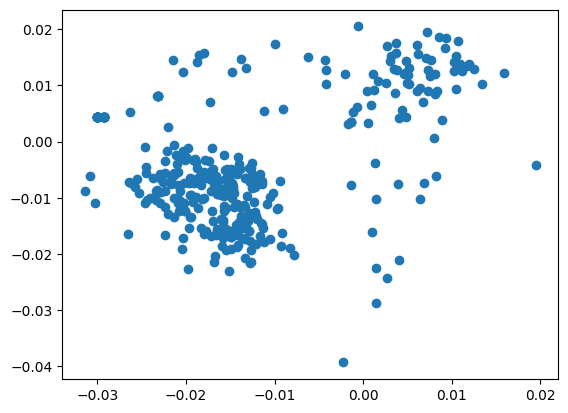

In [16]:
# Plot the data
import matplotlib.pyplot as plt

plt.scatter(matrix[:,0], matrix[:,1])
plt.show()

In [17]:
# Computer required parameters of DBSCAN clustering
# Use KNN to find the optimal epsilon
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find the optimal epsilon
nbrs = NearestNeighbors(n_neighbors=5).fit(matrix)

distances, indices = nbrs.kneighbors(matrix)

distances = np.sort(distances, axis=0)

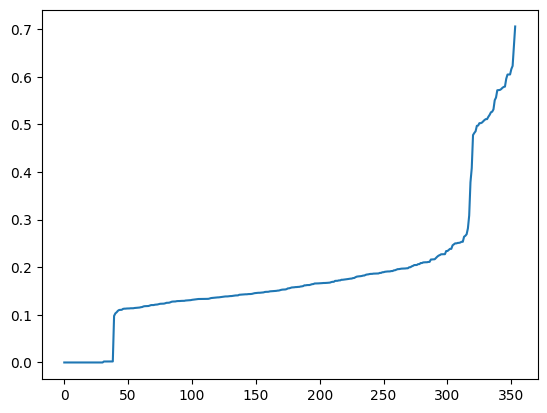

In [18]:
# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
import matplotlib.pyplot as plt

plt.plot(distances[:, 4])
plt.show()

In [19]:
# Use knee locator to find the optimal epsilon
from kneed import KneeLocator

kneedle = KneeLocator(
    range(1, distances.shape[0] + 1), distances[:, 1], curve="convex", direction="increasing"
)

kneedle.knee_y

0.4556534009118023

In [20]:
# Compute the DBSCAN clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=kneedle.knee_y, min_samples=3).fit(matrix)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the results
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 11
Estimated number of noise points: 14


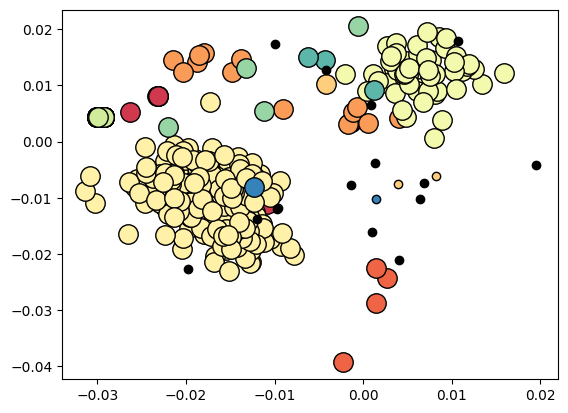

In [21]:
# Plot the results
import matplotlib.pyplot as plt

unique_labels = set(labels)
embs = np.array(embs)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embs[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embs[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6) 

In [22]:
# Create a dict of clusters and their bacnet devices
clusters = {}
for i in range(min(len(labels), len(documents))):
    if labels[i] in clusters:
        clusters[labels[i]].append(documents[i].page_content)
    else:
        clusters[labels[i]] = [documents[i].page_content]

# Pretty print the clusters dict
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters)

{   -1: [   'CHILLED/COND WATER is a  Chiller/Condenser Water System.',
            'MTIIChillerUC100001 is a  Chiller Unit.',
            'enteliBUS Manager 4104766 is a  Building Automation Controller.',
            'MTIIChillerUC200002 is a  Chiller Unit.',
            'Volttron BACnet driver is a  BACnet Driver.',
            'HOT WATER PLANT is a  Boiler or Hot Water Heater.',
            ' is a  Unknown/Not specified.',
            'Device_0030de05fef2 is a  Sensor.',
            'GARAGE EXHAUST is a  Exhaust Fan.',
            'WATT_BACnet is a  Wattmeter.',
            'WATT_BACnet_66005 is a  Wattmeter.',
            'DHW is a  Domestic Hot Water Heater.',
            'Dev_MSTP is a  Master-Slave/Token-Passing (MSTP) Device.',
            'WSHO-20 is a  Wall Switch Occupancy Sensor.'],
    0: [   'Engineering is a  Engineering Control System.',
           'Engineering is a  Engineering Control System.',
           'Engineering is a  Engineering Control System.'],
    1: [   'E

In [96]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# List of possible eps values
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# List of possible min_samples values
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Best score and corresponding parameters
best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(embs)
        labels = db.labels_
        score = silhouette_score(embs, labels)
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

print('Best eps:', best_eps)
print('Best min_samples:', best_min_samples)
print('Best silhouette score:', best_score)

Best eps: 0.8
Best min_samples: 2
Best silhouette score: 0.5370349014713187
